<a href="https://colab.research.google.com/github/GuoZhuyin/zhuyinasia/blob/main/MachineLearning/bank_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Marketing
目標：想知道哪些特徵及模型能精準預測客戶是否接受銀行定存行銷('y')

資料來源：[UCI Machine Learning Repository: Bank Marketing Data Set
](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

並且已試先將資料中的;透過notepad++全部取代為,

bank-additional.csv 為事先隨機挑好的訓練集，為bank-additional-full.csv的占比10%

bank-additional-full.csv 為全部銀行行銷定存資料

過程中有嘗試其他方式得出不同的精確率，不過最後決定將訓練及測試集的'month','day_of_week','campaign','poutcome','euribor3m','nr.employed'特徵丟掉

接著對前面七個特徵特別進行資料視覺化，讓我們更加清楚特徵

而預處理採用的方式為LabelEncoder( ),對非數值型資料進行預處理,其他原本為數值的資料則不進行處理

此次採用的模型有LogisticRegression、SVC、KNeighborsClassifier、RandomForestClassifier

最後計算所有常見的混淆矩陣評估指標

將數值畫成表格後，可以發現以此次的資料進行訓練時，似乎以RandomForestClassifier表現最好，想必未來如果有相關的行銷資料要進行分類預測，都能優先採用RandomForestClassifier進行型訓練

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #資料視覺化
import seaborn as sns #資料視覺化
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True) #掛載Google雲端
data_dir='/content/drive/MyDrive/亞洲大學/大三/機器學習/final_project'
os.chdir(data_dir) #cd檔案位置

Mounted at /content/drive


In [ ]:
! pwd

/content/drive/MyDrive/亞洲大學/大三/機器學習/final_project


In [ ]:
! ls -la #查看資料夾檔案及權限

total 6270
-rw------- 1 root root  583898 May  8 13:49 bank-additional.csv
-rw------- 1 root root 5834924 Oct  1  2019 bank-additional-full.csv
-rw------- 1 root root     679 May  8 13:49 feature_explain.csv


In [ ]:
bank_feature = pd.read_csv( 'feature_explain.csv' ) #對特徵進行解釋
bank_feature

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,年齡,工作,婚姻,教育,有無信用分數,有無房貸,有無個人借貸,聯絡方式,月,星期,...,聯繫次數,在此之前距離上次聯繫客戶的天數,在此之前與客戶聯繫次數,上次行銷結果,就業季度指數,月度消費者價格指數,月度消費者信心指數,Euribor指數,雇員季度指數,是否定存
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"""failure"",""nonexistent"",""success""",NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# bank_y= pd.read_csv('bank-additional.csv').iloc[: , 20]
# bank_all_y = pd.read_csv('bank-additional-full.csv').iloc[: , 20] #抓取y的結果
# #bank_y
# #bank_all_y

In [ ]:
bank = pd.read_csv('bank-additional.csv').drop(columns=['month','day_of_week','campaign','poutcome','euribor3m','nr.employed'])
bank
#事先丟掉不想要的特徵
#'age','job','marital','education','default','housing','loan','contact','month','day_of_week','duration','campaign','pdays','previous','poutcome','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'

,age,job,marital,education,default,housing,loan,contact,duration,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,487,999,0,-1.8,92.893,-46.2,no
1,39,services,single,high.school,no,no,no,telephone,346,999,0,1.1,93.994,-36.4,no
2,25,services,married,high.school,no,yes,no,telephone,227,999,0,1.4,94.465,-41.8,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,17,999,0,1.4,94.465,-41.8,no
4,47,admin.,married,university.degree,no,yes,no,cellular,58,999,0,-0.1,93.200,-42.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,53,999,0,1.4,93.918,-42.7,no
4115,39,admin.,married,high.school,no,yes,no,telephone,219,999,0,1.4,93.918,-42.7,no
4116,27,student,single,high.school,no,no,no,cellular,64,999,1,-1.8,92.893,-46.2,no
4117,58,admin.,married,high.school,no,no,no,cellular,528,999,0,1.4,93.444,-36.1,no


In [ ]:
bank_all = pd.read_csv('bank-additional-full.csv').drop(columns=['month','day_of_week','campaign','poutcome','euribor3m','nr.employed'])
bank_all
#事先丟掉不想要的特徵
#'age','job','marital','education','default','housing','loan','contact','month','day_of_week','duration','campaign','pdays','previous','poutcome','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'

,age,job,marital,education,default,housing,loan,contact,duration,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,261,999,0,1.1,93.994,-36.4,no
1,57,services,married,high.school,unknown,no,no,telephone,149,999,0,1.1,93.994,-36.4,no
2,37,services,married,high.school,no,yes,no,telephone,226,999,0,1.1,93.994,-36.4,no
3,40,admin.,married,basic.6y,no,no,no,telephone,151,999,0,1.1,93.994,-36.4,no
4,56,services,married,high.school,no,no,yes,telephone,307,999,0,1.1,93.994,-36.4,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,334,999,0,-1.1,94.767,-50.8,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,383,999,0,-1.1,94.767,-50.8,no
41185,56,retired,married,university.degree,no,yes,no,cellular,189,999,0,-1.1,94.767,-50.8,no
41186,44,technician,married,professional.course,no,no,no,cellular,442,999,0,-1.1,94.767,-50.8,yes


In [ ]:
bank_all.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'duration', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'y'],
      dtype='object')

In [ ]:
# bank.info()

In [ ]:
bank_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   duration        41188 non-null  int64  
 9   pdays           41188 non-null  int64  
 10  previous        41188 non-null  int64  
 11  emp.var.rate    41188 non-null  float64
 12  cons.price.idx  41188 non-null  float64
 13  cons.conf.idx   41188 non-null  float64
 14  y               41188 non-null  object 
dtypes: float64(3), int64(4), object(8)
memory usage: 4.7+ MB


## 資料視覺化

In [ ]:
bank_client = bank_all.iloc[: , 0:7] #僅取0-7作為特徵
bank_client

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes
...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no
41184,46,blue-collar,married,professional.course,no,no,no
41185,56,retired,married,university.degree,no,yes,no
41186,44,technician,married,professional.course,no,no,no


In [ ]:
print('Jobs:\n', bank_client['job'].unique())
print('age:\n', bank_client['age'].unique())
print('Education:\n', bank_client['education'].unique())
print('Default:\n', bank_client['default'].unique())
print('Housing:\n', bank_client['housing'].unique())
print('Loan:\n', bank_client['loan'].unique()) #顯示出每個特徵變量

Jobs:
 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
age:
 [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
Education:
 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Default:
 ['no' 'unknown' 'yes']
Housing:
 ['no' 'yes' 'unknown']
Loan:
 ['no' 'yes' 'unknown']


In [ ]:
print('Min age: ', bank_client['age'].max())
print('Max age: ', bank_client['age'].min())
print('Null Values: ', bank_client['age'].isnull().any())

Min age:  98
Max age:  17
Null Values:  False


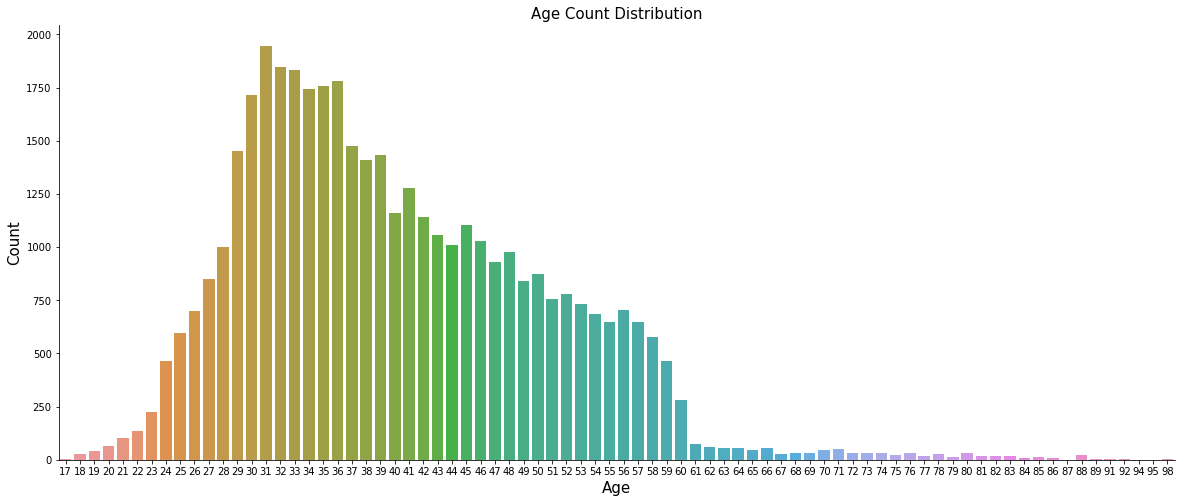

In [ ]:
fig, ax = plt.subplots() #畫圖
fig.set_size_inches(20, 8) #圖的大小
sns.countplot(x = 'age', data = bank_client) #抓取年齡資料
ax.set_xlabel('Age', fontsize=15) #x軸
ax.set_ylabel('Count', fontsize=15) #y軸
ax.set_title('Age Count Distribution', fontsize=15) #圖表名稱
sns.despine() #移除邊框

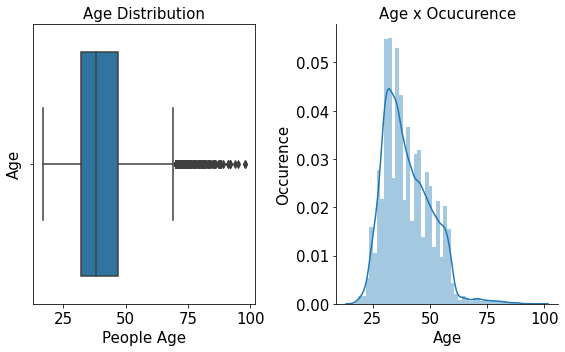

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 5)) #nrow列 ncols欄 figsize圖表大小
sns.boxplot(x = 'age', data = bank_client, orient = 'v', ax = ax1)
ax1.set_xlabel('People Age', fontsize=15)
ax1.set_ylabel('Age', fontsize=15)
ax1.set_title('Age Distribution', fontsize=15)
ax1.tick_params(labelsize=15) #更改方格大小

sns.distplot(bank_client['age'], ax = ax2)
sns.despine(ax = ax2) #將兩個樣式大小相同
ax2.set_xlabel('Age', fontsize=15)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Age x Ocucurence', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.6)
plt.tight_layout() 

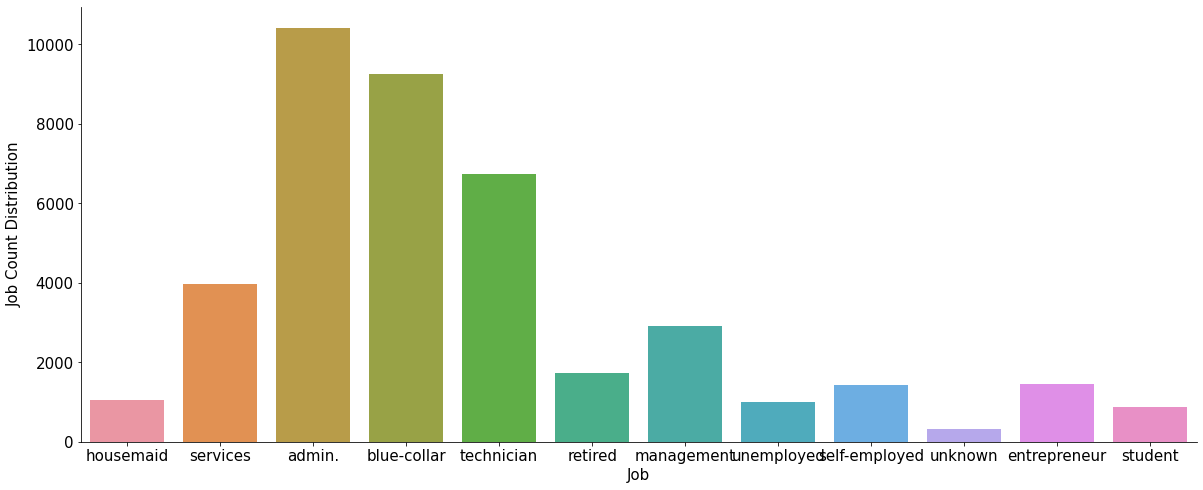

In [ ]:
# 這家銀行的客戶有什麼樣的工作，如果違約 貸款 或住房 工作交叉比對，有沒有關係
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'job', data = bank_client)      #工作
ax.set_xlabel('Job', fontsize=15)
ax.set_ylabel('Job Count Distribution', fontsize=15)  #工作長條圖分佈   
ax.tick_params(labelsize=15)
sns.despine()

## 資料預處理

In [ ]:
# y=pd.get_dummies(bank['y'], columns = ['y'], prefix = ['y'], drop_first = True) #對y行資料進行one hot encoding
# y_all=pd.get_dummies(bank_all['y'], columns = ['y'], prefix = ['y'], drop_first = True) #對y行資料進行one hot encoding

In [ ]:
labelencoder_x = LabelEncoder() #類別型標籤編碼，對於非數值型數據進行資料預處理
bank['job'] = labelencoder_x.fit_transform(bank['job']) 
bank['marital'] = labelencoder_x.fit_transform(bank['marital']) 
bank['education'] = labelencoder_x.fit_transform(bank['education'])
bank['default'] = labelencoder_x.fit_transform(bank['default'])
bank['housing'] = labelencoder_x.fit_transform(bank['housing'])
bank['loan'] = labelencoder_x.fit_transform(bank['loan'])
bank['contact'] = labelencoder_x.fit_transform(bank['contact'])
bank['y'] = labelencoder_x.fit_transform(bank['y'])
bank_all['job'] = labelencoder_x.fit_transform(bank_all['job']) 
bank_all['marital'] = labelencoder_x.fit_transform(bank_all['marital']) 
bank_all['education'] = labelencoder_x.fit_transform(bank_all['education'])
bank_all['default'] = labelencoder_x.fit_transform(bank_all['default'])
bank_all['housing'] = labelencoder_x.fit_transform(bank_all['housing'])
bank_all['loan'] = labelencoder_x.fit_transform(bank_all['loan'])
bank_all['contact'] = labelencoder_x.fit_transform(bank_all['contact'])
bank_all['y'] = labelencoder_x.fit_transform(bank_all['y'])

In [ ]:
# x_train = bank[['age','job','marital','education']] #要輸入的訓練特徵
# #pd.get_dummies(bank, columns = ['job','marital','education'], prefix = ['job','marital','education'] ,drop_first = True)
# y_train = pd.get_dummies(bank_y, columns = ['y'], prefix = ['y'] , drop_first = True) #輸入x將預測的y，用來訓練模型用，這裡y是指銀行行銷是否成功
# x_test = bank_all[['age','job','marital','education']] #要輸入的測試特徵
# #pd.get_dummies(bank_all, columns = ['job','marital','education'], prefix = ['job','marital','education'] ,drop_first = True)
# y_test = pd.get_dummies(bank_all_y, columns = ['y'], prefix = ['y'], drop_first = True) #計算出正解y與模型結果的準確率
# #訓練集為bank-additional.csv 測試集為bank-additional-full.csv

In [ ]:
x_train = bank.drop(columns=['y']) #輸入要的訓練特徵,除了'y'行其他特徵都要
y_train = bank['y'] #輸入x將預測的y，用來訓練模型用，這裡y是指銀行行銷是否成功
x_test = bank_all.drop(columns=['y']) #輸入要的測試特徵,除了'y'行其他特徵都要
y_test = bank_all['y'] #計算出正解y與模型結果的準確率
#訓練集為bank-additional.csv 測試集為bank-additional-full.csv

## Model

[[35589   959]
 [ 2916  1724]]
90.59 %


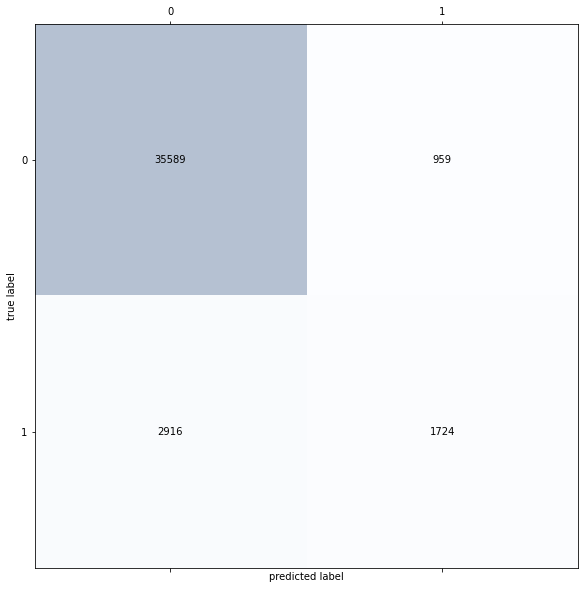

In [ ]:
from sklearn.linear_model import LogisticRegression #採用邏輯式回歸模型
logmodel = LogisticRegression() 
logmodel.fit(x_train,y_train)
logpred = logmodel.predict(x_test)
confu_log = confusion_matrix(y_test, logpred)
print(confu_log)
print(round(accuracy_score(y_test, logpred),4)*100,'%')
LOGCV = (cross_val_score(logmodel, x_train, y_train, scoring = 'accuracy').mean())
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(confu_log, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confu_log.shape[0]):
    for j in range(confu_log.shape[1]):
        ax.text(x=j, y=i, s=confu_log[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()
#yes=1 , no=0

[[36293   255]
 [ 3851   789]]
90.03 %


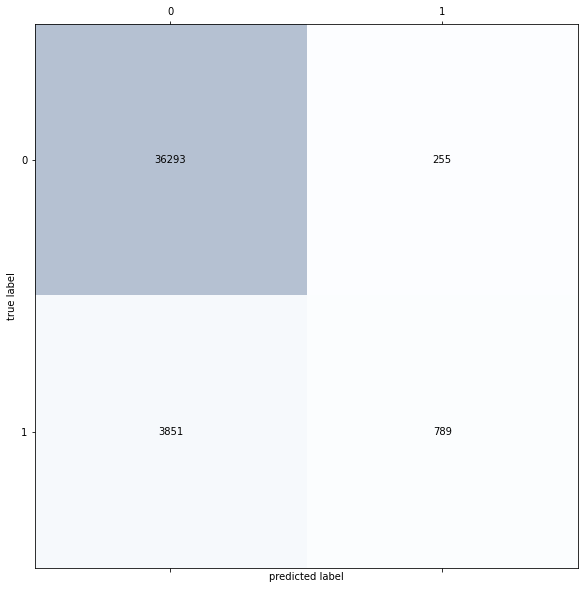

In [ ]:
from sklearn.svm import SVC #採用SVC支援向量機模型
svc= SVC(kernel = 'sigmoid')
svc.fit(x_train, y_train)
svcpred = svc.predict(x_test)
confu_svc=confusion_matrix(y_test, svcpred)
print(confu_svc)
print(round(accuracy_score(y_test, svcpred),4)*100,'%')
SVCCV = (cross_val_score(svc, x_train, y_train,scoring = 'accuracy').mean())
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(confu_svc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confu_svc.shape[0]):
    for j in range(confu_svc.shape[1]):
        ax.text(x=j, y=i, s=confu_svc[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()
#yes=1 , no=0

[[35649   899]
 [ 2995  1645]]
90.55 %


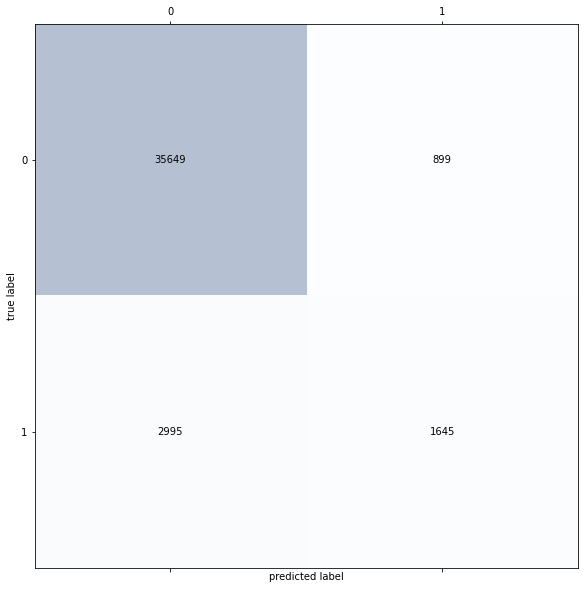

In [ ]:
from sklearn.neighbors import KNeighborsClassifier #採用K近鄰投票算法分類器模型
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train,y_train)
knnpred=knn.predict(x_test)
confu_knn=confusion_matrix(y_test, knnpred)
print(confusion_matrix(y_test,knnpred))
print(round(accuracy_score(y_test, knnpred),4)*100,'%')
KNNCV = (cross_val_score(knn, x_train, y_train,scoring = 'accuracy').mean())
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(confu_knn, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confu_knn.shape[0]):
  for j in range(confu_knn.shape[1]):
    ax.text(x=j, y=i, s=confu_knn[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()
#yes=1 , no=0

[[35516  1032]
 [ 2389  2251]]
91.69 %


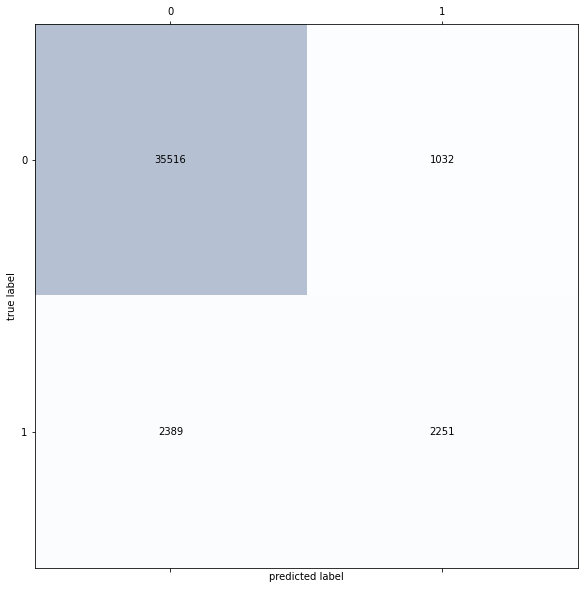

In [ ]:
from sklearn.ensemble import RandomForestClassifier #採用隨機分類森林
rfc = RandomForestClassifier(n_estimators = 200)#criterion = entopy,gini
rfc.fit(x_train, y_train)
rfcpred = rfc.predict(x_test)
confu_rfc=confusion_matrix(y_test, rfcpred)

print(confu_rfc)
print(round(accuracy_score(y_test, rfcpred),4)*100,'%')
RFCCV = (cross_val_score(rfc, x_train, y_train, scoring = 'accuracy').mean())
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(confu_rfc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confu_rfc.shape[0]):
    for j in range(confu_rfc.shape[1]):
        ax.text(x=j, y=i, s=confu_rfc[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()
#yes=1 , no=0

##Score

$$\text{Precision}= {TP \over TP + FP }$$

$$\text{Recall}= {TP \over TP + FN }$$

$$\text{Accuracy}= {TP + TN \over TP + FP + FN +TN }$$

$$\text{F1-score}= 2 \times {(Precision \times Recall) \over (Precision + Recall) }$$

In [ ]:
TP_log=confu_log[0,0]
FP_log=confu_log[0,1]
FN_log=confu_log[1,0]
TN_log=confu_log[1,1]
Precision_log=round((TP_log/(TP_log+FP_log)),4)*100
Recall_log=round((TP_log/(TP_log+FN_log)),4)*100
Accuracy_log = round(((TP_log+TN_log)/(TP_log+FP_log+FN_log+TN_log)),4)*100
F1_score_log = round((2*Precision_log*Recall_log/(Precision_log+Recall_log)),2)
print('LogisticRegression:')
print('\tPrecision:', Precision_log,'%') #準確率
print('\tRecall:', Recall_log,'%') #召回率
print('\tAccuracy:', Accuracy_log,'%') #精確率
print('\tF1-score:', F1_score_log,'%')
#F1-score：是「precision」和「recall」的調和平均數（harmonic mean），可看作是該二指標的綜合指標

LogisticRegression:
	Precision: 97.38 %
	Recall: 92.43 %
	Accuracy: 90.59 %
	F1-score: 94.84 %


In [ ]:
TP_svc=confu_svc[0,0]
FP_svc=confu_svc[0,1]
FN_svc=confu_svc[1,0]
TN_svc=confu_svc[1,1]
Precision_svc=round((TP_svc/(TP_svc+FP_svc)),4)*100
Recall_svc=round((TP_svc/(TP_svc+FN_svc)),4)*100
Accuracy_svc = round(((TP_svc+TN_svc)/(TP_svc+FP_svc+FN_svc+TN_svc)),4)*100
F1_score_svc = round((2*Precision_svc*Recall_svc/(Precision_svc+Recall_svc)),2)
print('SVC:')
print('\tPrecision:', Precision_svc,'%') #準確率
print('\tRecall:', Recall_svc,'%') #召回率
print('\tAccuracy:', Accuracy_svc,'%') #精確率
print('\tF1-score:', F1_score_svc,'%')
#F1-score：是「precision」和「recall」的調和平均數（harmonic mean），可看作是該二指標的綜合指標

SVC:
	Precision: 99.3 %
	Recall: 90.41 %
	Accuracy: 90.03 %
	F1-score: 94.65 %


In [ ]:
TP_knn=confu_knn[0,0]
FP_knn=confu_knn[0,1]
FN_knn=confu_knn[1,0]
TN_knn=confu_knn[1,1]
Precision_knn=round((TP_knn/(TP_knn+FP_knn)),4)*100
Recall_knn=round((TP_knn/(TP_knn+FN_knn)),4)*100
Accuracy_knn = round(((TP_knn+TN_knn)/(TP_knn+FP_knn+FN_knn+TN_knn)),4)*100
F1_score_knn = round((2*Precision_knn*Recall_knn/(Precision_knn+Recall_knn)),2)
print('KNeighborsClassifier:')
print('\tPrecision:', Precision_knn,'%') #準確率
print('\tRecall:', Recall_knn,'%') #召回率
print('\tAccuracy:', Accuracy_knn,'%') #精確率
print('\tF1-score:', F1_score_knn,'%')
#F1-score：是「precision」和「recall」的調和平均數（harmonic mean），可看作是該二指標的綜合指標

KNeighborsClassifier:
	Precision: 97.54 %
	Recall: 92.25 %
	Accuracy: 90.55 %
	F1-score: 94.82 %


In [ ]:
TP_rfc=confu_rfc[0,0]
FP_rfc=confu_rfc[0,1]
FN_rfc=confu_rfc[1,0]
TN_rfc=confu_rfc[1,1]
Precision_rfc=round((TP_rfc/(TP_rfc+FP_rfc)),4)*100
Recall_rfc=round((TP_rfc/(TP_rfc+FN_rfc)),4)*100
Accuracy_rfc = round(((TP_rfc+TN_rfc)/(TP_rfc+FP_rfc+FN_rfc+TN_rfc)),4)*100
F1_score_rfc = round((2*Precision_rfc*Recall_rfc/(Precision_rfc+Recall_rfc)),2)
print('RandomForestClassifier:')
print('\tPrecision:', Precision_rfc,'%') #準確率
print('\tRecall:', Recall_rfc,'%') #召回率
print('\tAccuracy:', Accuracy_rfc,'%') #精確率
print('\tF1-score:', F1_score_rfc,'%')
#F1-score：是「precision」和「recall」的調和平均數（harmonic mean），可看作是該二指標的綜合指標

RandomForestClassifier:
	Precision: 97.18 %
	Recall: 93.7 %
	Accuracy: 91.69 %
	F1-score: 95.41 %


##Result

In [ ]:
col_name=['LogisticRegression','SVC','KNeighborsClassifier','RandomForestClassifier']
row_name=['Precision','Recall','Accuracy','F1-score']
score_data=[[Precision_log,Precision_svc,Precision_knn,Precision_rfc],
            [Recall_log,Recall_svc,Recall_knn,Recall_rfc],
            [Accuracy_log,Accuracy_svc,Accuracy_knn,Accuracy_rfc],
            [F1_score_log,F1_score_svc,F1_score_knn,F1_score_rfc]]

(0.0, 1.0, 0.0, 1.0)

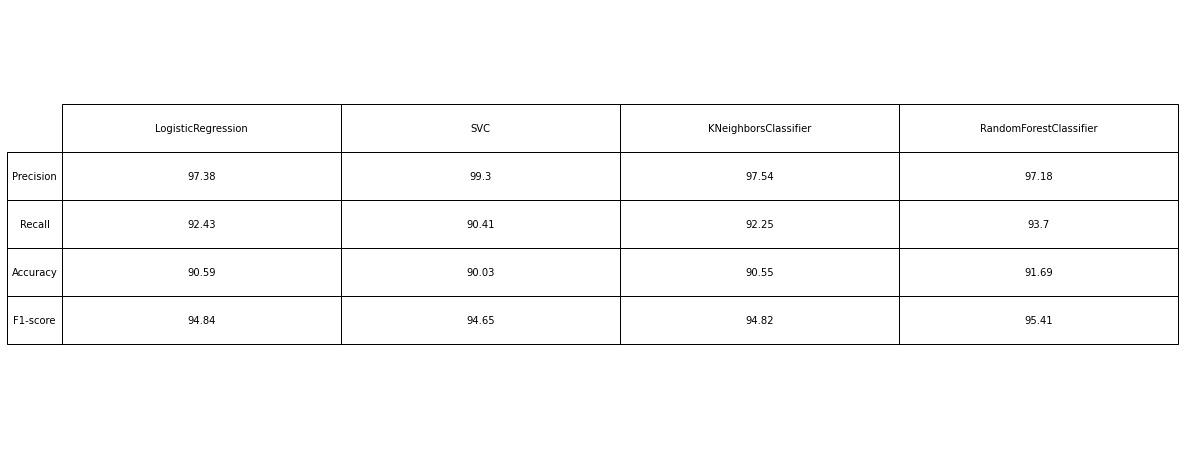

In [ ]:
plt.figure(figsize=(20,8))
tab = plt.table(cellText=score_data,
                colLabels=col_name,
                rowLabels=row_name,
                loc='center',
                cellLoc='center',
                rowLoc='center')
tab.scale(1,4)
plt.axis('off')